# Machine learning with Spark MLlib

For this project, there will be no "walkthrough", you will be free to do your own machine learning, as long as you follow these guidelines:

1. Choose **any** dataset from http://archive.ics.uci.edu/ml/index.php
2. Download the dataset file and upload to Databricks. If you want to use another dataset, it's okay as long as it's public.
3. Explore it using DataFrames, including **at least** the following steps:
  1. Reading the file into a DataFrame
  2. Running some aggregations and explorations using DataFrame functions
4. Your solution notebook must have a part using MLlib, including **at least** the following steps:
  1. Converting into MLlib matrix
  2. Applying some statistics with the  MLlib's API
  3. Learning a classification or regression model
  4. Applying the model to the test data and computing the errors
5. You'll also train another model using Pipelines:
  1. Creating a pipeline with **at least** one feature extraction/manipulation and one model estimator
  2. Fitting the pipeline to the training data
  3. Applying the model to the test data and computing the errors
6. Finally you should try to apply a third party ML library for instance [tune scikit-learn meta-parameters using spark](https://docs.databricks.com/spark/latest/mllib/third-party-libraries.html#scikit-learn).
7. No report needed !! Just add some comment as part of the Notebook. The notebook should be self-sufficient. I'm expecting a short written analysis (and you should know that "We found nothing after testing *this* and *that* is already a valuable result), but also some plots. You can use any library (matplotlib, bokeh...). Just be sure to [watch this video first](https://www.youtube.com/watch?v=xAoljeRJ3lU)

Notes: 
  - Don't forget to split your data into training and test (and validation if you want) sets
  - Your code should be readable. ** DO NO FORGET [PEP8](https://www.python.org/dev/peps/pep-0008/)**
  - You can do this project in groups of **4 members**
  - All submissions after the deadlines won't be considered
    - **It's much better to submit an incomplete solution than nothing at all!**
  - If you have any question or problem, don't hesitate to send me an e-mail; I try to answer as quickly as possible (usually under 24h)
  - If you want to use this project as a display of your skills, you can upload it on github when you're done. It's a good opportunity (and for some tech companies, a github can be better than a resume). If you're not sure how, let me know, I'll help you and give you advise on how to make it look pretty. **This could be really important for you if you're targeting tech jobs**
  - Even if it seems obvious, **do not cheat**. I won't be nice if I suspect it.
  
Resources:
  - [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)
  - [Databricks MLlib guide](https://docs.databricks.com/spark/latest/mllib/index.html#)
  - [pyspark MLlib RDD API docs](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html)
  - [pyspark MLlib DataFrame API docs](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html)
  - [pyspark complete docs](https://spark.apache.org/docs/latest/api/python/)
  - [Course Homepage](https://waterponey.github.io/SparkCourse/)
  
### May the force be with you!

We chose the wine dataset from the machine learning repository. This dataset is a famous kaggle dataset aiming at predicting a wine quality (mark between 1 and 10) from different chemical characteristics

below all needed libraries

In [4]:
import hashlib
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from collections import namedtuple

from pyspark.sql import functions as fn
from pyspark.sql.types import *
from pyspark.sql import Row, Column
from pyspark.mllib.stat import Statistics
from pyspark.mllib import classification as clt
from pyspark.mllib.linalg.distributed import *
from pyspark.mllib.linalg import Matrix, Matrices

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.externals import joblib

/databricks/python/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
 "This module will be removed in 0.20.", DeprecationWarning)

In [5]:
def hash(x):
  return hashlib.sha1(str(x).encode('utf-8')).hexdigest()

assert sys.version_info.major == 3

# 3.1 Loading data


Loading the data into spark dataframe. We have two dataset. One for white wine and the second for red wine. We had a new column to each dataframe specifying the group each wine belongs. 1 for white wine groupe and 0 for red wine group.

In [7]:
# Loading the data and adding a column specifying the 'wine type': 'red' or 'white'

whiteWinePath = '/FileStore/tables/winequality_white-d3c3e.csv'
whiteWine = spark.read.csv(whiteWinePath, sep = ';', header = True,
                           inferSchema = True)
whiteWine = whiteWine.withColumn('wineType', fn.lit(1))

redWinePath = '/FileStore/tables/winequality_red-42ff5.csv'
redWine = spark.read.csv(redWinePath, sep = ';', header = True,
                         inferSchema = True)
redWine = redWine.withColumn('wineType', fn.lit(0))

combining the two dataframe to get a unique one

In [9]:
wineData = whiteWine.union(redWine)
wineData.printSchema()
variables = list(set(wineData.columns) - set(['wineType', 'quality']))

root
-- fixed acidity: double (nullable = true)
-- volatile acidity: double (nullable = true)
-- citric acid: double (nullable = true)
-- residual sugar: double (nullable = true)
-- chlorides: double (nullable = true)
-- free sulfur dioxide: double (nullable = true)
-- total sulfur dioxide: double (nullable = true)
-- density: double (nullable = true)
-- pH: double (nullable = true)
-- sulphates: double (nullable = true)
-- alcohol: double (nullable = true)
-- quality: integer (nullable = true)
-- wineType: integer (nullable = false)

In [10]:
display(wineData.take(4))

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wineType
7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,1
6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,1
8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.4,9.9,6,1


In [11]:
print('the total number of white wine and red wine are respectively {n1} and {n2}.'
      .format(n1 = wineData.where(wineData.wineType == 1).count(), 
              n2 = wineData.where(wineData.wineType == 0).count()))

the total number of white wine and red wine are respectively 4898 and 1599.

# 3.2 Dataframe exploration


below we have the min, max for all variables for the global dataset

We first take a look at our data distribution:

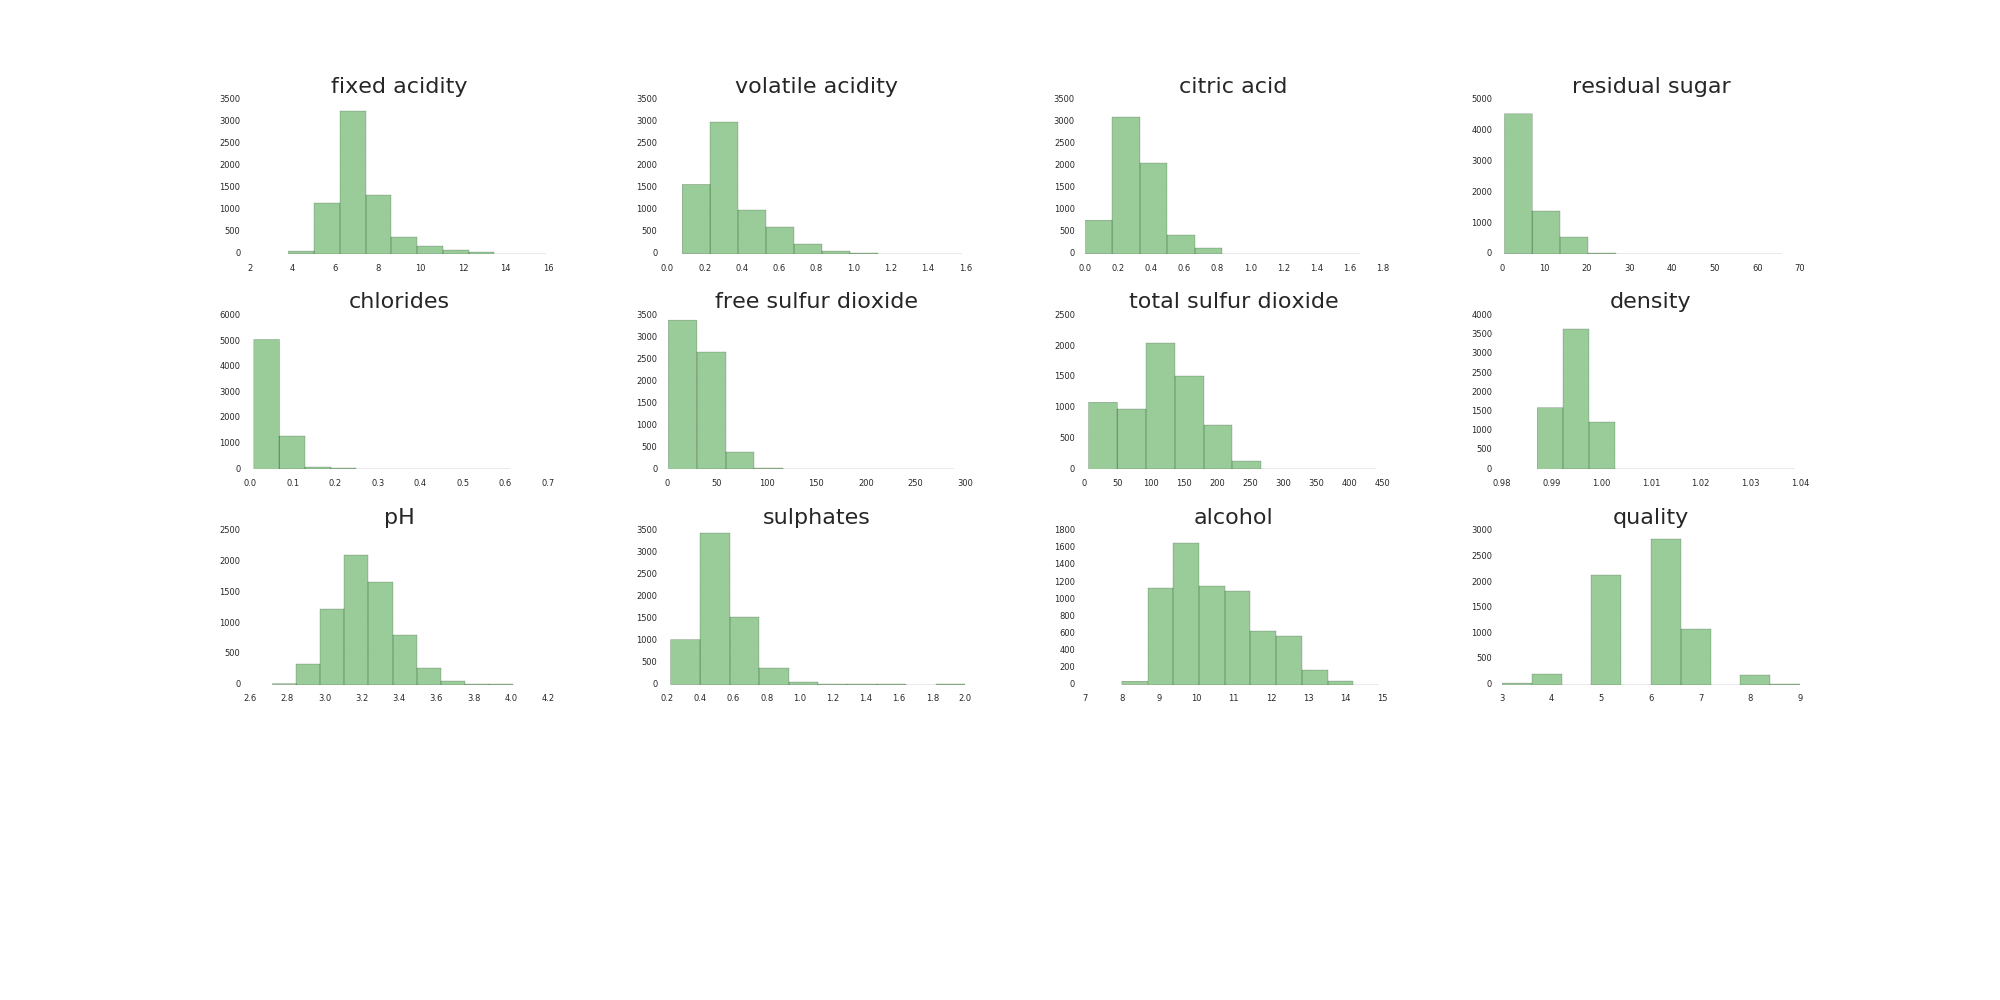

In [14]:
plt.rcParams["figure.figsize"] = 20,10
fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for elt in wineData.columns[:-1]:
    ax = fig.add_subplot(4,4, wineData.columns.index(elt)+1)
    tmp = sns.distplot(wineData.select(elt).take(4898+1599), hist = True, kde = False, bins = 10, color = 'green')
    plt.xticks(fontsize = 6)
    plt.yticks(fontsize = 6)
    plt.title(elt, fontsize = 16)
display(fig)

# Could also have been obtained with
# display(wineData.show())

In [15]:
tmp = wineData.describe(wineData.columns).select("summary", 
                                                 *[fn.round(c).alias(c) for c in wineData.columns[:-1]])
tmp2 = wineData.select(*[fn.countDistinct(c).alias(c) 
                         for c in wineData.columns[:-1]]).withColumn("summary", 
                                                                     fn.lit("unique count")).select("summary",
                                                                                                    "fixed acidity",
                                                                                                    "volatile acidity",
                                                                                                    "citric acid", 
                                                                                                    "residual sugar",
                                                                                                    "chlorides",
                                                                                                    "free sulfur dioxide",
                                                                                                    "total sulfur dioxide",
                                                                                                    "density",
                                                                                                     "pH", 
                                                                                                    "sulphates",
                                                                                                    "alcohol",
                                                                                                    "quality")
display(tmp.union(tmp2))
del tmp, tmp2

summary,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0
mean,7.0,0.0,0.0,5.0,0.0,31.0,116.0,1.0,3.0,1.0,10.0,6.0
stddev,1.0,0.0,0.0,5.0,0.0,18.0,57.0,0.0,0.0,0.0,1.0,1.0
min,4.0,0.0,0.0,1.0,0.0,1.0,6.0,1.0,3.0,0.0,8.0,3.0
max,16.0,2.0,2.0,66.0,1.0,289.0,440.0,1.0,4.0,2.0,15.0,9.0
unique count,106.0,187.0,89.0,316.0,214.0,135.0,276.0,998.0,108.0,111.0,111.0,7.0


It might be interesting to have such information, per type of wine:

In [17]:
tmp0 = wineData.where(wineData.wineType == 0).describe(wineData.columns).select("summary", 
                                                                                *[fn.round(c).alias(c) for c in wineData.columns[:-1]])
print(display(tmp0))

summary,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0
mean,8.0,1.0,0.0,3.0,0.0,16.0,46.0,1.0,3.0,1.0,10.0,6.0
stddev,2.0,0.0,0.0,1.0,0.0,10.0,33.0,0.0,0.0,0.0,1.0,1.0
min,5.0,0.0,0.0,1.0,0.0,1.0,6.0,1.0,3.0,0.0,8.0,3.0
max,16.0,2.0,1.0,16.0,1.0,72.0,289.0,1.0,4.0,2.0,15.0,8.0


In [18]:
tmp1 = wineData.where(wineData.wineType == 1).describe(wineData.columns).select("summary", 
                                                                                *[fn.round(c).alias(c) for c in wineData.columns[:-1]])
display(tmp1)

del tmp0, tmp1

summary,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0
mean,7.0,0.0,0.0,6.0,0.0,35.0,138.0,1.0,3.0,0.0,11.0,6.0
stddev,1.0,0.0,0.0,5.0,0.0,17.0,42.0,0.0,0.0,0.0,1.0,1.0
min,4.0,0.0,0.0,1.0,0.0,2.0,9.0,1.0,3.0,0.0,8.0,3.0
max,14.0,1.0,2.0,66.0,0.0,289.0,440.0,1.0,4.0,1.0,14.0,9.0


when we compare we can see that only the 2 columns concerning the sulfur dioxide present some big differences wetween the two types of wine.
If we pay attention to the scale of the variable, the residual sugar can be also considered as really different.

focus on the variable quality

In [21]:
qualitySummary = wineData.groupby('quality').count()


white = [(i,wineData.where((wineData.quality == i) & (wineData.wineType == 1)).count()) for i in range(3,10)]
data = spark.createDataFrame(sc.parallelize(white), ['quality', 'white'])
qualitySummary = qualitySummary.join(data, 'quality')

red = [(i,wineData.where((wineData.quality == i) & (wineData.wineType == 0)).count()) for i in range(3,10)]
data = spark.createDataFrame(sc.parallelize(red), ['quality', 'red'])
qualitySummary = qualitySummary.join(data, 'quality')

qualitySummary.sort('quality').show()
del data

+-------+-----+-----+---+
quality|count|white|red|
+-------+-----+-----+---+
 3| 30| 20| 10|
 4| 216| 163| 53|
 5| 2138| 1457|681|
 6| 2836| 2198|638|
 7| 1079| 880|199|
 8| 193| 175| 18|
 9| 5| 5| 0|
+-------+-----+-----+---+

It's not surprising to see that the great majority of all wines are of "average" quality.

Now, we will focus on the quantity of alcohol contained in wines.
We will first show the 10 wines with the highest quantity of alcohol and see that only 3 of them are white. 
Concerning the 10 wines having the lower quantiny of alcohol, only 2 are red.

The histograms right after shows that indeed, the wines with high quality of alcohol are likeky to be red, whereas the ones with low quantity of alcohol tend to be white

In [24]:
wineData.select('wineType','alcohol').sort('alcohol',
                                           ascending = False).show(10)

+--------+-------+
wineType|alcohol|
+--------+-------+
 0| 14.9|
 1| 14.2|
 1| 14.05|
 1| 14.0|
 0| 14.0|
 0| 14.0|
 0| 14.0|
 0| 14.0|
 0| 14.0|
 0| 14.0|
+--------+-------+
only showing top 10 rows

In [25]:
#The 10 wine  with the lowest quantity of alcohol are the following:
wineData.select('wineType','alcohol').sort('alcohol').show(10)

+--------+-------+
wineType|alcohol|
+--------+-------+
 1| 8.0|
 1| 8.0|
 0| 8.4|
 0| 8.4|
 1| 8.4|
 1| 8.4|
 1| 8.4|
 1| 8.5|
 1| 8.5|
 1| 8.5|
+--------+-------+
only showing top 10 rows

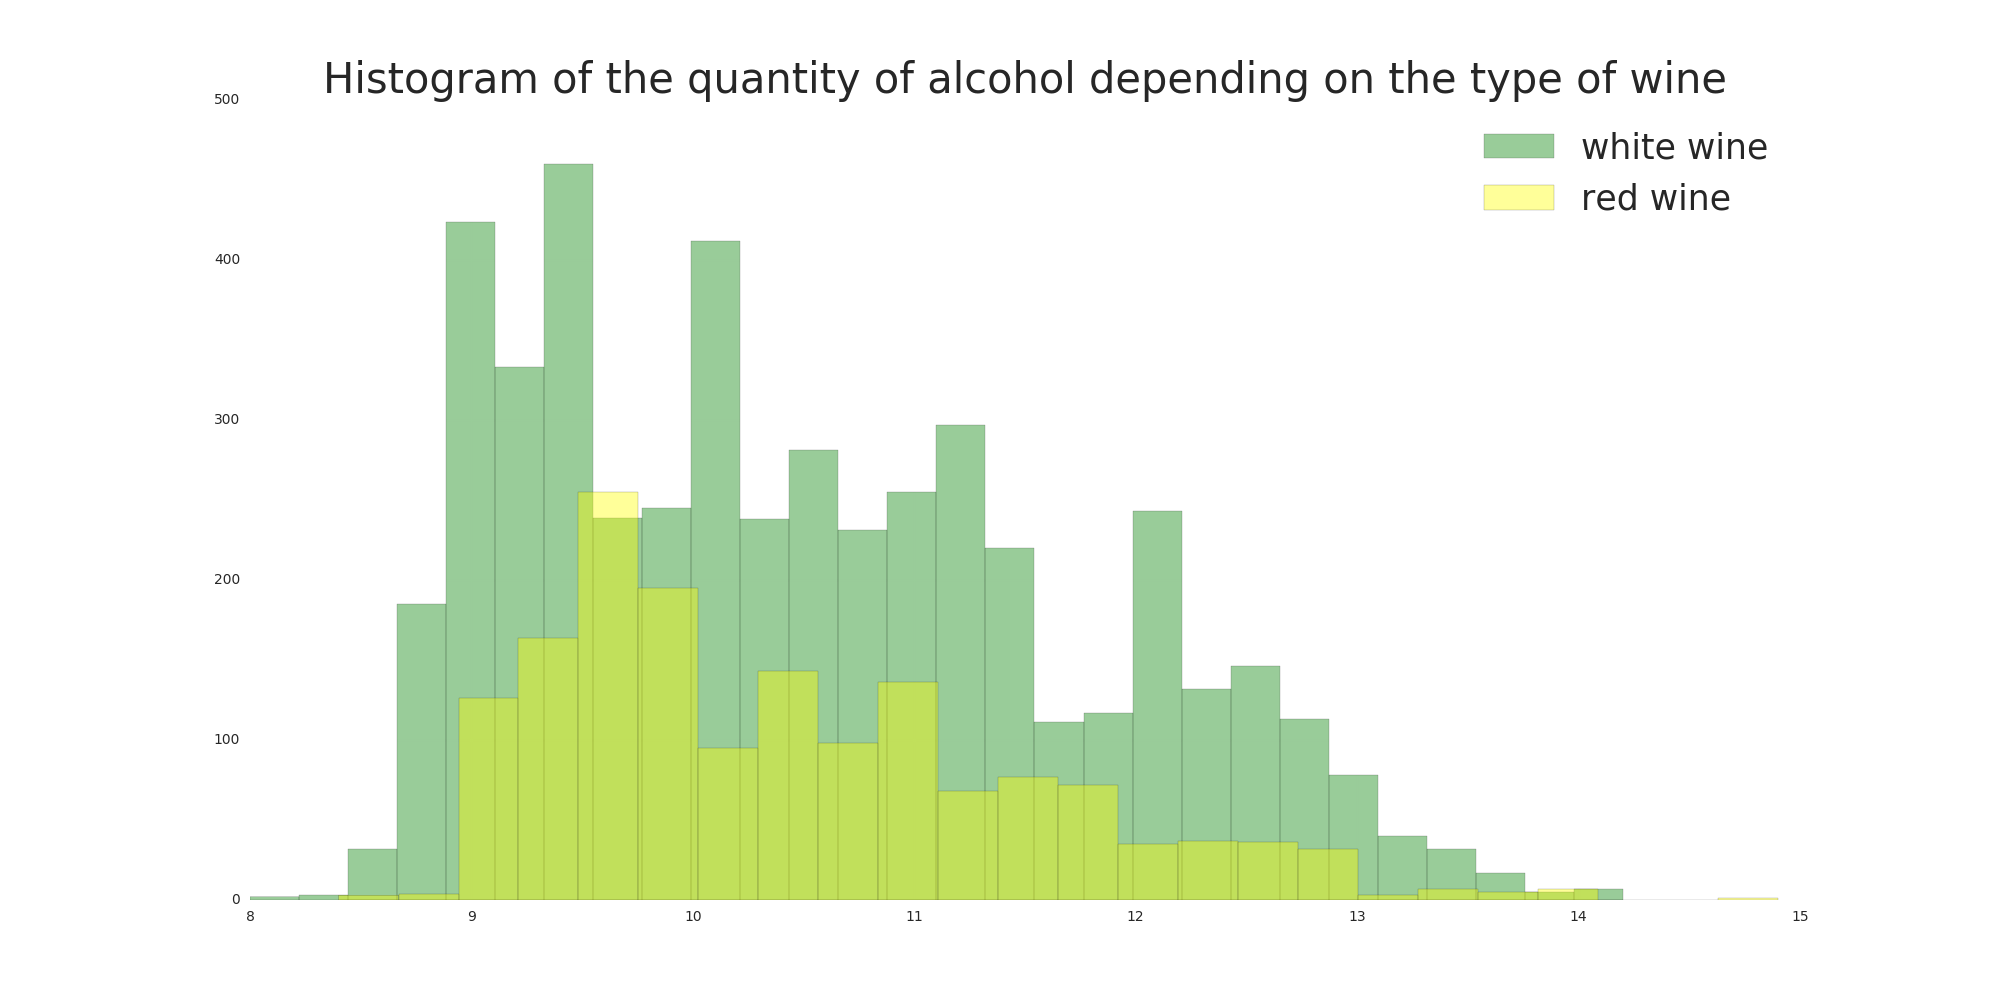

In [26]:
fig = plt.figure()
sns.distplot(wineData.select('alcohol').where(wineData.wineType == 1).take(4898),
             hist = True,
             kde =False,
             color = 'green',
             label = 'white wine')
sns.distplot(wineData.select('alcohol').where(wineData.wineType == 0).take(1599),
             hist = True,
             kde = False,
             color = 'yellow',
             label = 'red wine')
plt.legend(fontsize = 25)
plt.title('Histogram of the quantity of alcohol depending on the type of wine', fontsize = 30)
display(fig)

Now, we look at the number of wine with lowest quantity of alcohol by types using the following table: There are 2 white wine with quantity of alcohol = 8.0, ...

In [28]:
wineData.sort('alcohol', ascending = True).groupBy(['wineType', 
                                                    wineData.alcohol]).count().show(10)

+--------+-------+-----+
wineType|alcohol|count|
+--------+-------+-----+
 1| 8.0| 2|
 1| 8.4| 3|
 0| 8.4| 2|
 1| 8.5| 9|
 0| 8.5| 1|
 1| 8.6| 23|
 1| 8.7| 78|
 0| 8.7| 2|
 1| 8.8| 107|
 0| 8.8| 2|
+--------+-------+-----+
only showing top 10 rows

We now focus on the quantity of residual sugar contains in wines.

The 10 wine  with the highest residual sugar are the following: all of them are white.

In fact, even the 100 firsts are, which can be undestood by seing the associated histogram

In [31]:
wineData.select('wineType','residual sugar').sort('residual sugar', ascending = False).show(10)

+--------+--------------+
wineType|residual sugar|
+--------+--------------+
 1| 65.8|
 1| 31.6|
 1| 31.6|
 1| 26.05|
 1| 26.05|
 1| 23.5|
 1| 22.6|
 1| 22.0|
 1| 22.0|
 1| 20.8|
+--------+--------------+
only showing top 10 rows

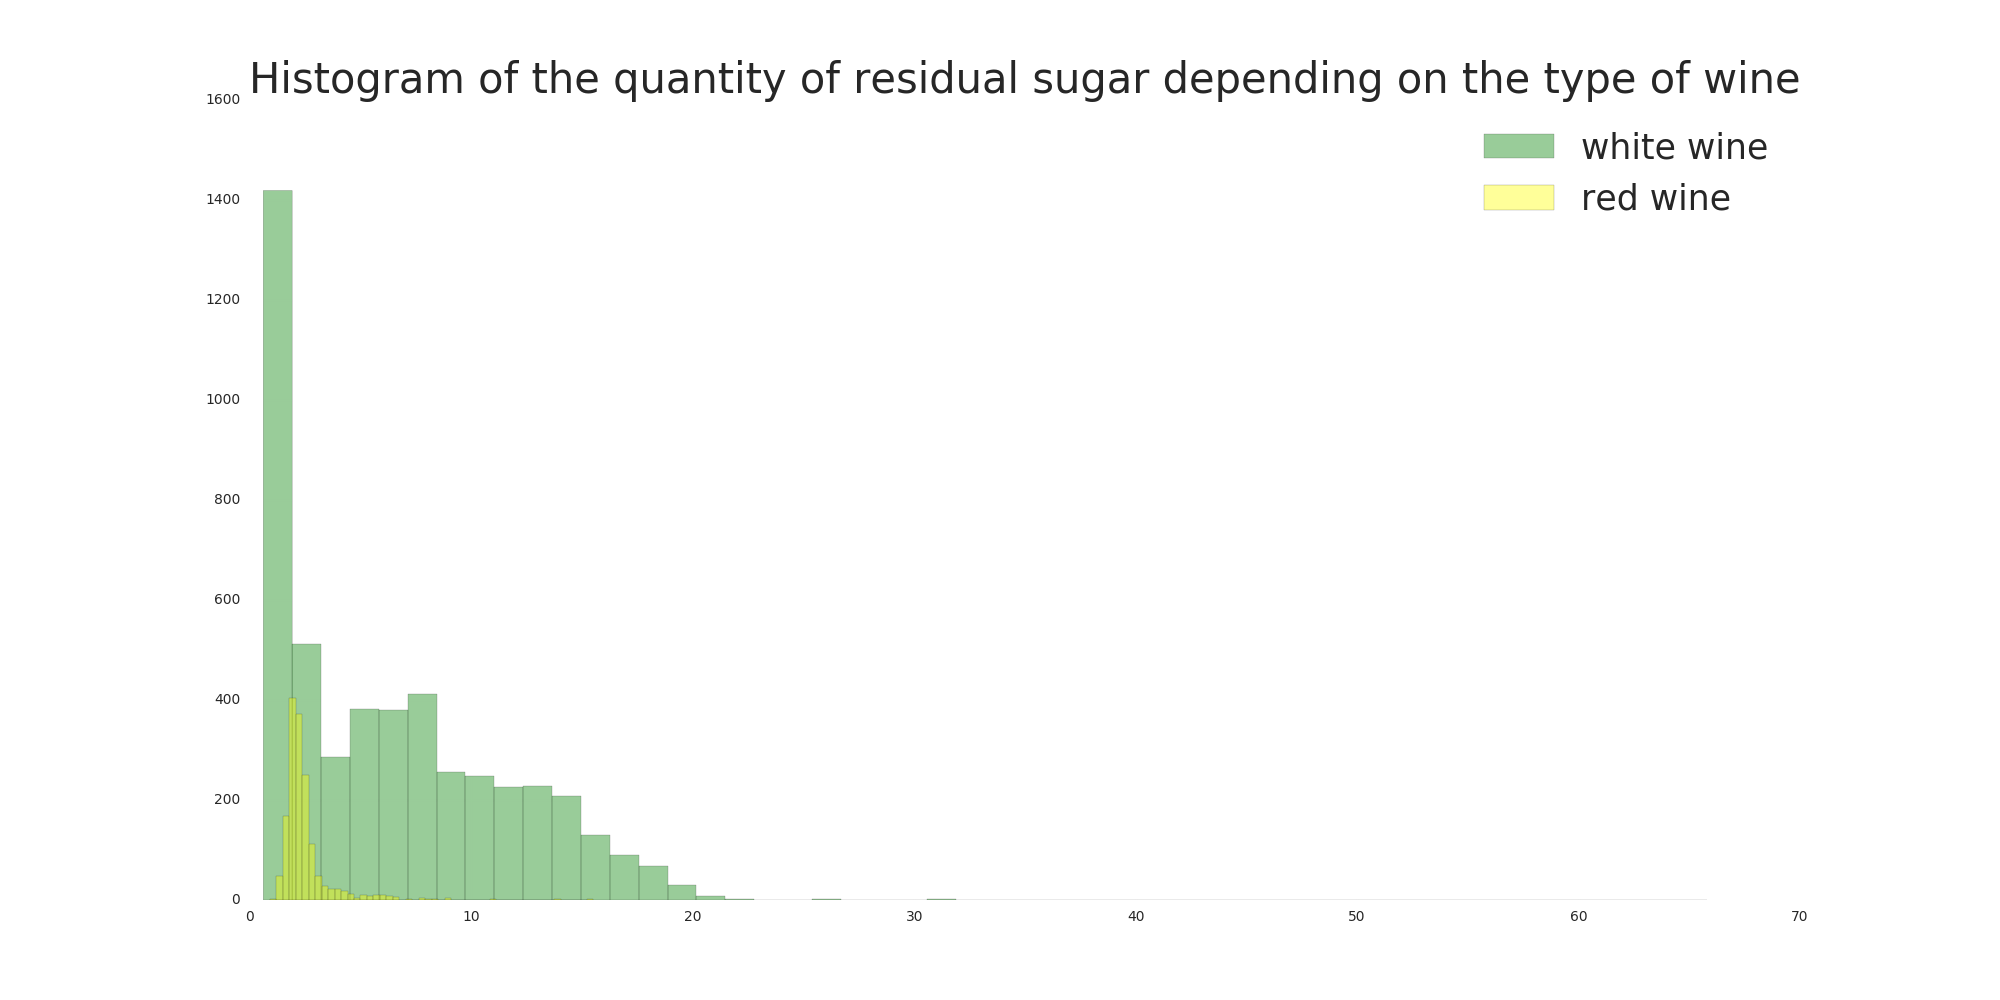

In [32]:
fig = plt.figure()
sns.distplot(wineData.select('residual sugar').where(wineData.wineType == 1).take(4898),
             hist = True,
             kde =False,
             color = 'green',
             label = 'white wine')
sns.distplot(wineData.select('residual sugar').where(wineData.wineType == 0).take(1599),
             hist = True,
             kde = False,
             color = 'yellow',
             label = 'red wine')
plt.legend(fontsize = 25)
plt.title('Histogram of the quantity of residual sugar depending on the type of wine', fontsize = 30)
display(fig)

Now, we focus on the quantity of acidity of wines: the lower the pH, the higher the acidity.

We will see that the most acide wines are red (except one).
Then, even thought the PH variable's greater values are related to red wones, the top 10 is balanced.

In [34]:
wineData.select('wineType','PH').sort('PH').show(10)

+--------+----+
wineType| PH|
+--------+----+
 1|2.72|
 1|2.74|
 0|2.74|
 1|2.77|
 1|2.79|
 1|2.79|
 1|2.79|
 1| 2.8|
 1| 2.8|
 1| 2.8|
+--------+----+
only showing top 10 rows

In [35]:
wineData.select('wineType','PH').sort('PH', ascending=False).show(10)

+--------+----+
wineType| PH|
+--------+----+
 0|4.01|
 0|4.01|
 0| 3.9|
 0| 3.9|
 0|3.85|
 1|3.82|
 1|3.81|
 1| 3.8|
 1| 3.8|
 1|3.79|
+--------+----+
only showing top 10 rows

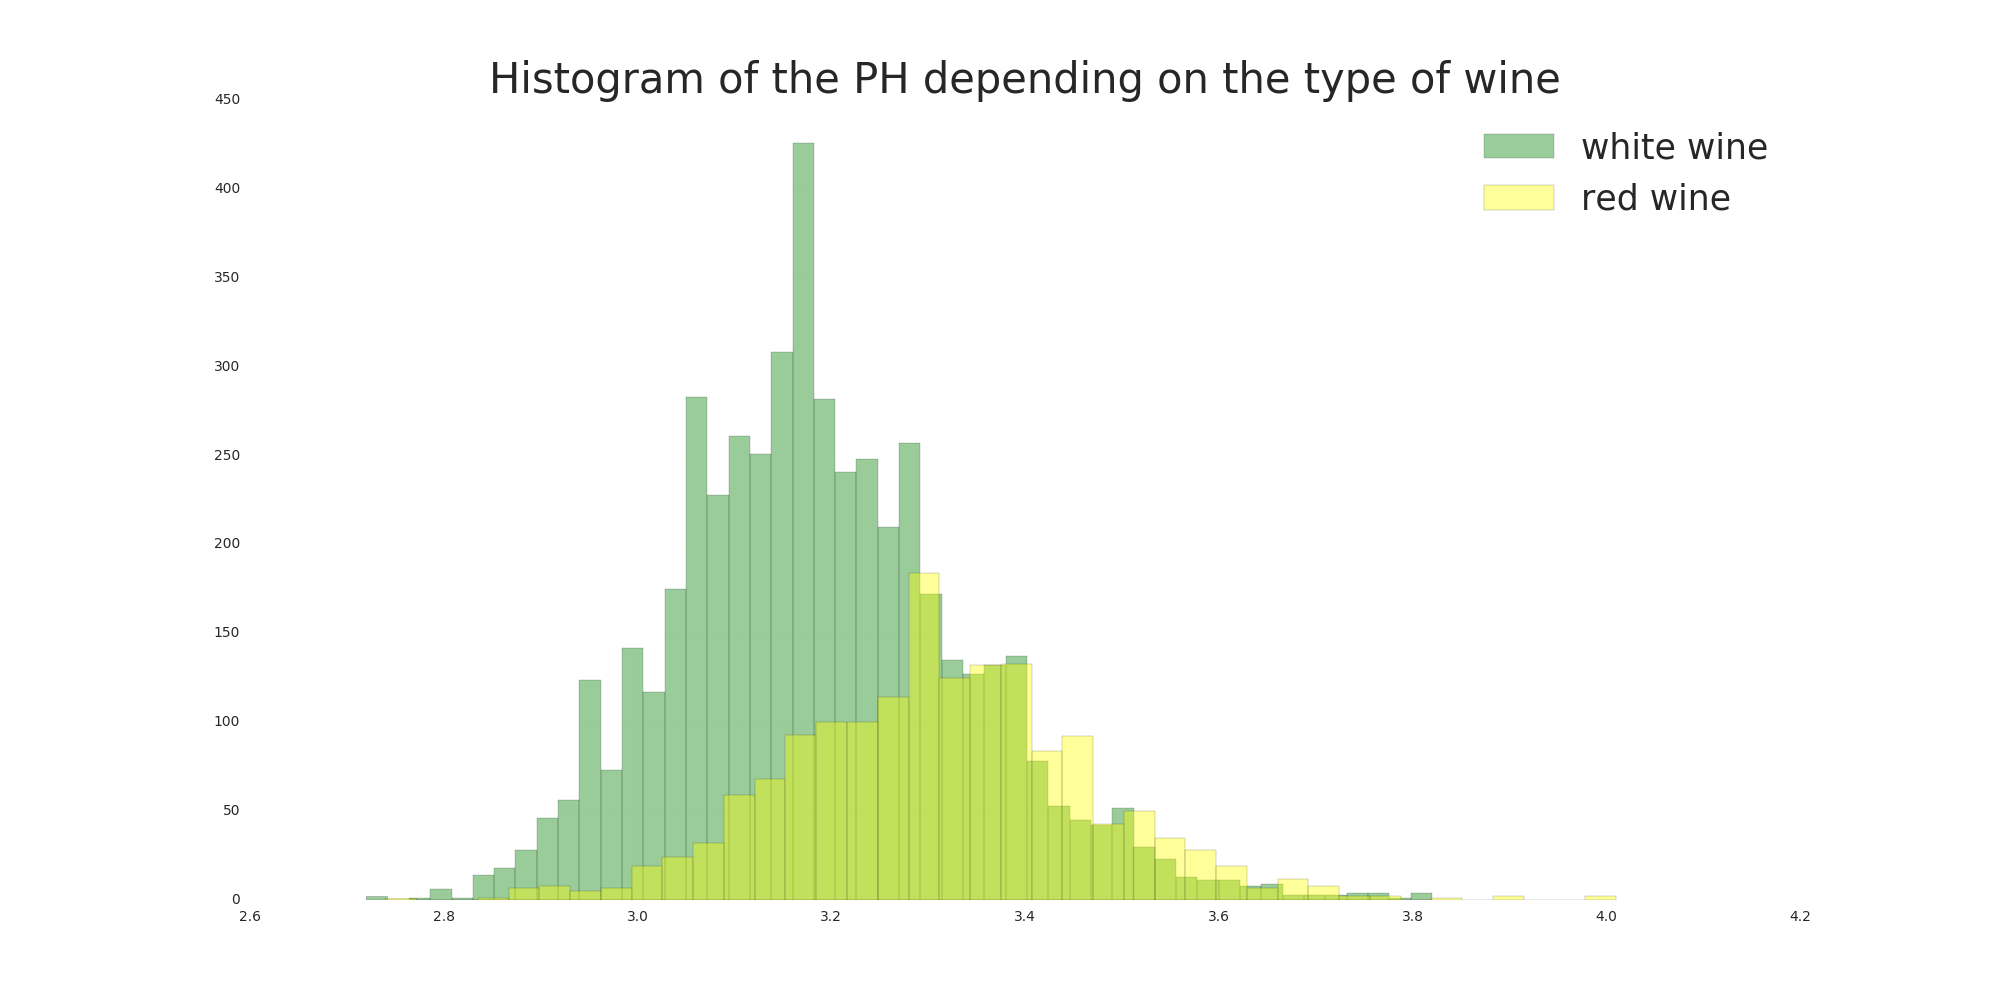

In [36]:
fig = plt.figure()
sns.distplot(wineData.select('PH').where(wineData.wineType == 1).take(4898),
             hist = True,
             kde =False,
             color = 'green',
             label = 'white wine')
sns.distplot(wineData.select('PH').where(wineData.wineType == 0).take(1599),
             hist = True,
             kde = False,
             color = 'yellow',
             label = 'red wine')
plt.legend(fontsize = 25)
plt.title('Histogram of the PH depending on the type of wine', fontsize = 30)
display(fig)

The histograms above show us that the white wines tends to be more acid than the red ones.

The 10 wine that have high score of quality and less alcohol are the following:

In [39]:
wineData.select('wineType',
                'quality',
                'alcohol').where((wineData.quality > 6)
                                 & (wineData.alcohol < 10)).sort('quality',
                                                                 acsending = False).show(10)

As we talked about 3 variables where there was a significant difference between white and red wines, and we already talked about one of them (residual sugar), here is a histogram giving some details about the total sulfur dioxide.

As we thought, ce can easily distioguish two groups.

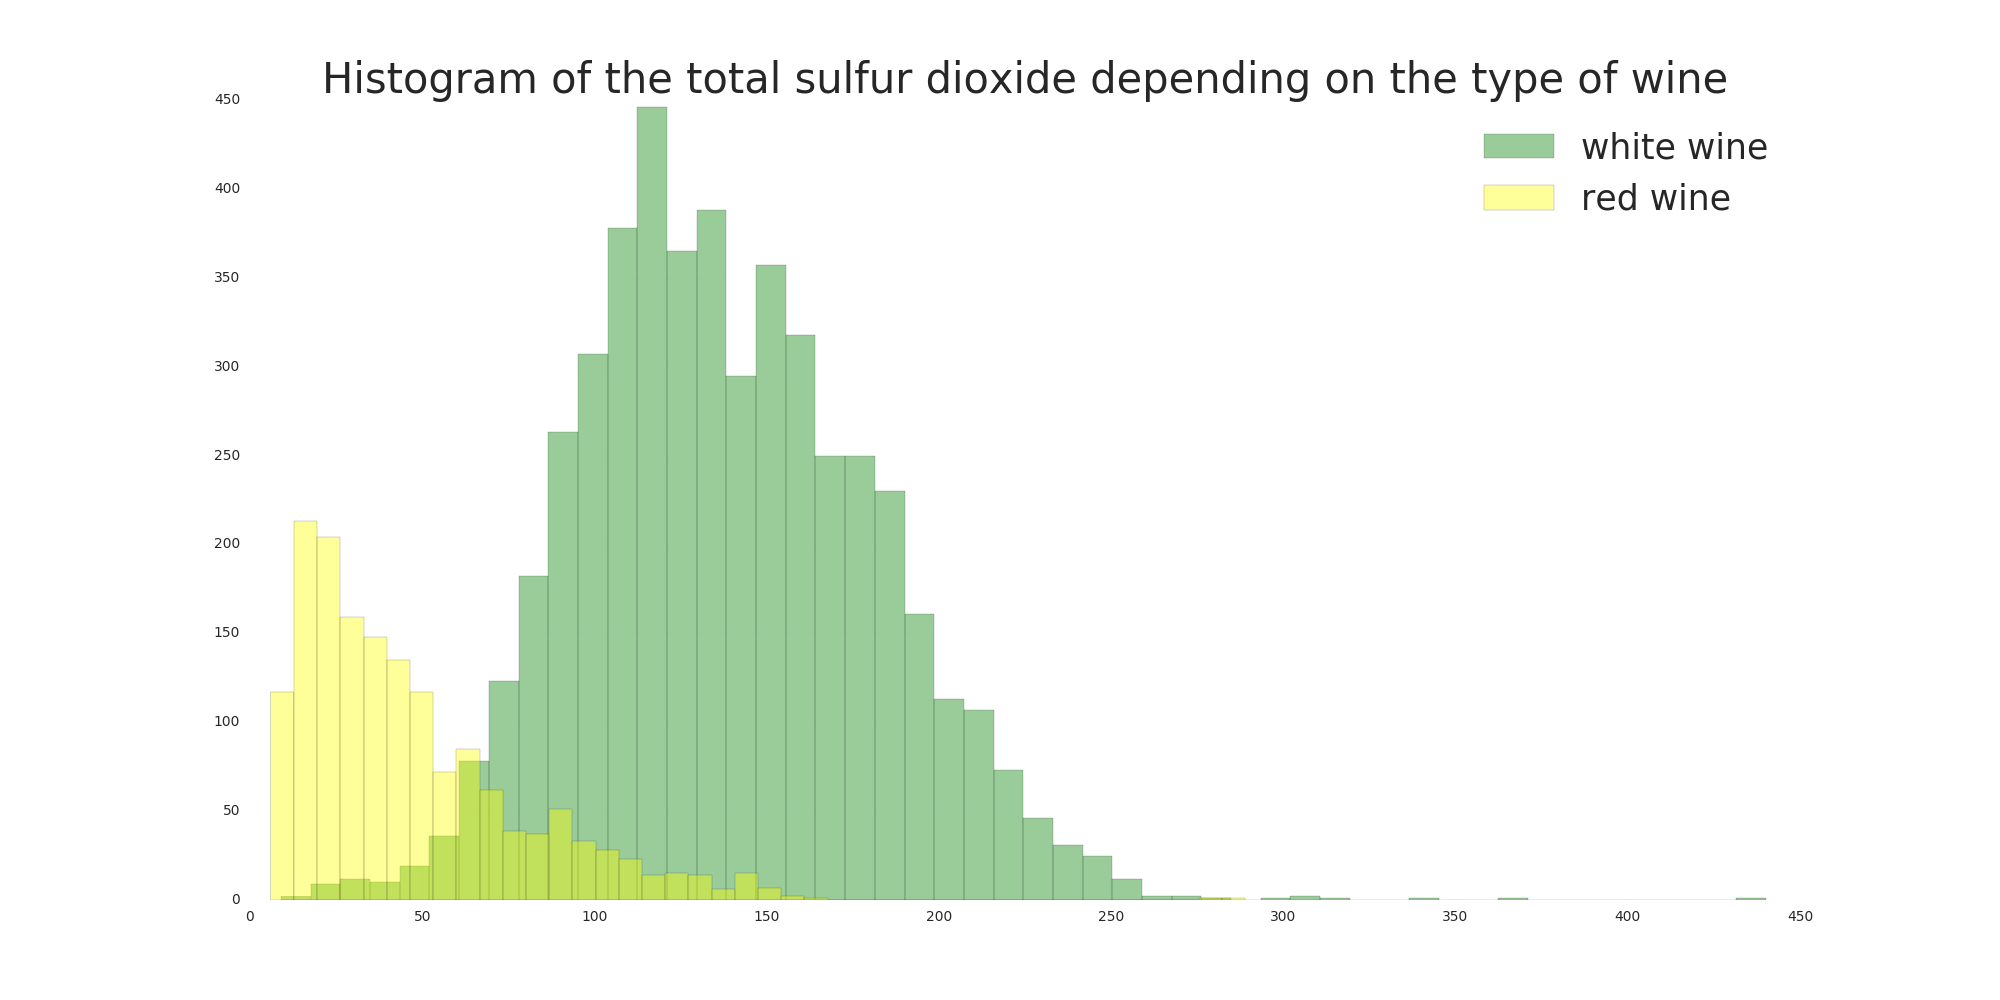

In [41]:
fig = plt.figure()
sns.distplot(wineData.select('total sulfur dioxide').where(wineData.wineType == 1).take(4898),
             hist = True,
             kde =False,
             color = 'green',
             label = 'white wine')
sns.distplot(wineData.select('total sulfur dioxide').where(wineData.wineType == 0).take(1599),
             hist = True,
             kde = False,
             color = 'yellow',
             label = 'red wine')
plt.legend(fontsize = 25)
plt.title('Histogram of the total sulfur dioxide depending on the type of wine', fontsize = 30)
display(fig)

# 4. Library Mllib part

## 4.1 Mllib matrix transformation


Convert dataframe into mllib matrix

To build our matrix, we first define a function that take  each row of a data frame and return an array with element of this row. Then, we use is to define our matrix.

In [44]:
def rowToList(row):
  cleanRow = ([row[i] for i in range(len(row)-1)]) 
  return np.array([x for x in cleanRow])

wineDataRDD = wineData.rdd
wineDataMatrix = wineDataRDD.map(rowToList)
wineDataMatrix.take(4)

Out[ 99 ]: 
[array([ 7.00000000e+00, 2.70000000e-01, 3.60000000e-01,
 2.07000000e+01, 4.50000000e-02, 4.50000000e+01,
 1.70000000e+02, 1.00100000e+00, 3.00000000e+00,
 4.50000000e-01, 8.80000000e+00, 6.00000000e+00]),
 array([ 6.30000000e+00, 3.00000000e-01, 3.40000000e-01,
 1.60000000e+00, 4.90000000e-02, 1.40000000e+01,
 1.32000000e+02, 9.94000000e-01, 3.30000000e+00,
 4.90000000e-01, 9.50000000e+00, 6.00000000e+00]),
 array([ 8.10000000e+00, 2.80000000e-01, 4.00000000e-01,
 6.90000000e+00, 5.00000000e-02, 3.00000000e+01,
 9.70000000e+01, 9.95100000e-01, 3.26000000e+00,
 4.40000000e-01, 1.01000000e+01, 6.00000000e+00]),
 array([ 7.20000000e+00, 2.30000000e-01, 3.20000000e-01,
 8.50000000e+00, 5.80000000e-02, 4.70000000e+01,
 1.86000000e+02, 9.95600000e-01, 3.19000000e+00,
 4.00000000e-01, 9.90000000e+00, 6.00000000e+00])]

## 4.2 Statistics on Mllib matrix

#### 4.2.1 Basic Statistics on Mllib matrix

Then, we first computes the basics statistics of each variables.

In [48]:
variables1 = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides','free sulfur dioxide']
variables2 = ['total sulfur dioxide','density', 'PH', 'sulphates', 'alcohol', 'quality']
variables = variables1 + variables2

summaryStats = Statistics.colStats(wineDataMatrix)

summaryMatrix = [ summaryStats.min(), summaryStats.mean(),
summaryStats.max()]


pd.set_option('display.max_columns', len(variables))

colNames = variables
rowNames = [ "Min", "Mean", "Max"]

summaryDf = pd.DataFrame( summaryMatrix, 
                    index=rowNames, 
                    columns=colNames)

print(summaryDf)

fixed acidity volatile acidity citric acid residual sugar chlorides \
Min 3.800000 0.080000 0.000000 0.600000 0.009000 
Mean 7.215307 0.339666 0.318633 5.443235 0.056034 
Max 15.900000 1.580000 1.660000 65.800000 0.611000 

 free sulfur dioxide total sulfur dioxide density PH \
Min 1.000000 6.000000 0.987110 2.720000 
Mean 30.525319 115.744574 0.994697 3.218501 
Max 289.000000 440.000000 1.038980 4.010000 

 sulphates alcohol quality 
Min 0.220000 8.000000 3.000000 
Mean 0.531268 10.491801 5.818378 
Max 2.000000 14.900000 9.000000

Then we computes the correlation coefficient between the variables.

In [50]:
correlation_matrix = Statistics.corr(wineDataMatrix, method="spearman")

pd.set_option('display.max_columns', len(variables))

col_names = variables

corr_df = pd.DataFrame(correlation_matrix, 
                    index=col_names, 
                    columns=col_names)

display(corr_df)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,PH,sulphates,alcohol,quality
1.0,0.20027175377939013,0.2705679150280595,-0.032253701992199735,0.355964118515899,-0.25991418193063637,-0.2332586214600812,0.43405621482022455,-0.2500440255679894,0.22014500369946538,-0.11065013949311156,-0.09815443194054146
0.20027175377939013,1.0,-0.2951287387423041,-0.06438414511905766,0.4158958312666248,-0.36567327125387417,-0.3435342001455942,0.26143698981159885,0.19487560523377764,0.2550419991503119,-0.023924199542388502,-0.25780590107223944
0.2705679150280595,-0.2951287387423041,1.0,0.07491958677809143,-0.07408447720522263,0.12205750378408549,0.15935478372232367,0.0656898683285511,-0.28590509847348733,0.036898069248017834,0.019652965910119932,0.10571082724096133
-0.032253701992199735,-0.06438414511905766,0.07491958677809143,1.0,-0.035800048572820736,0.38774959097921535,0.45488602922629323,0.5266638133180755,-0.22934417379217384,-0.13815698720962144,-0.32921790708278686,-0.016890589767888358
0.355964118515899,0.4158958312666248,-0.07408447720522263,-0.035800048572820736,1.0,-0.2604212825927448,-0.26843408696371734,0.5907291229270879,0.1635275092505291,0.3704495179112228,-0.40127036934982835,-0.29505424731327096
-0.25991418193063637,-0.36567327125387417,0.12205750378408549,0.38774959097921535,-0.2604212825927448,1.0,0.7414377922868332,0.005840650671234627,-0.1646991538539784,-0.22106150656279364,-0.18604649624781203,0.08686507174087786
-0.2332586214600812,-0.3435342001455942,0.15935478372232367,0.45488602922629323,-0.26843408696371734,0.7414377922868332,1.0,0.06153997198162494,-0.24271856017280963,-0.25674489207149975,-0.3089823881456476,-0.05477719627767607
0.43405621482022455,0.26143698981159885,0.0656898683285511,0.5266638133180755,0.5907291229270879,0.005840650671234627,0.06153997198162494,1.0,0.011777326023225485,0.2747915947316961,-0.6994424737473537,-0.32280604836451116
-0.2500440255679894,0.19487560523377764,-0.28590509847348733,-0.22934417379217384,0.1635275092505291,-0.1646991538539784,-0.24271856017280963,0.011777326023225485,1.0,0.25426331139763075,0.14022486806119772,0.03253771558466202
0.22014500369946538,0.2550419991503119,0.036898069248017834,-0.13815698720962144,0.3704495179112228,-0.22106150656279364,-0.25674489207149975,0.2747915947316961,0.25426331139763075,1.0,0.004583412376846752,0.029830500119469968


Now we want those variables that are highly correlated. For that we do a bit of dataframe manipulation.
we first get a boolean dataframe where true means that a pair of variables is highly correlated.

In [52]:
highly_correlated_df = (abs(corr_df) > .7) & (corr_df < 1.0)

# get the names of the variables so we can use them to slice the dataframe
correlated_vars_index = (highly_correlated_df==True).any()
correlated_var_names = correlated_vars_index[correlated_vars_index==True].index

# slice it
highly_correlated_df.loc[correlated_var_names,correlated_var_names]

Out[ 110 ]: 
 free sulfur dioxide total sulfur dioxide
free sulfur dioxide False True
total sulfur dioxide True False

#### 4.2.2 Graphical Statistics on Mllib matrix

To make plot on  our data, we proceed as follows:

In [55]:
wineRdd = sc.parallelize(wineData.rdd.map(lambda x : list(x)).collect())
summary = Statistics.colStats(wineRdd)

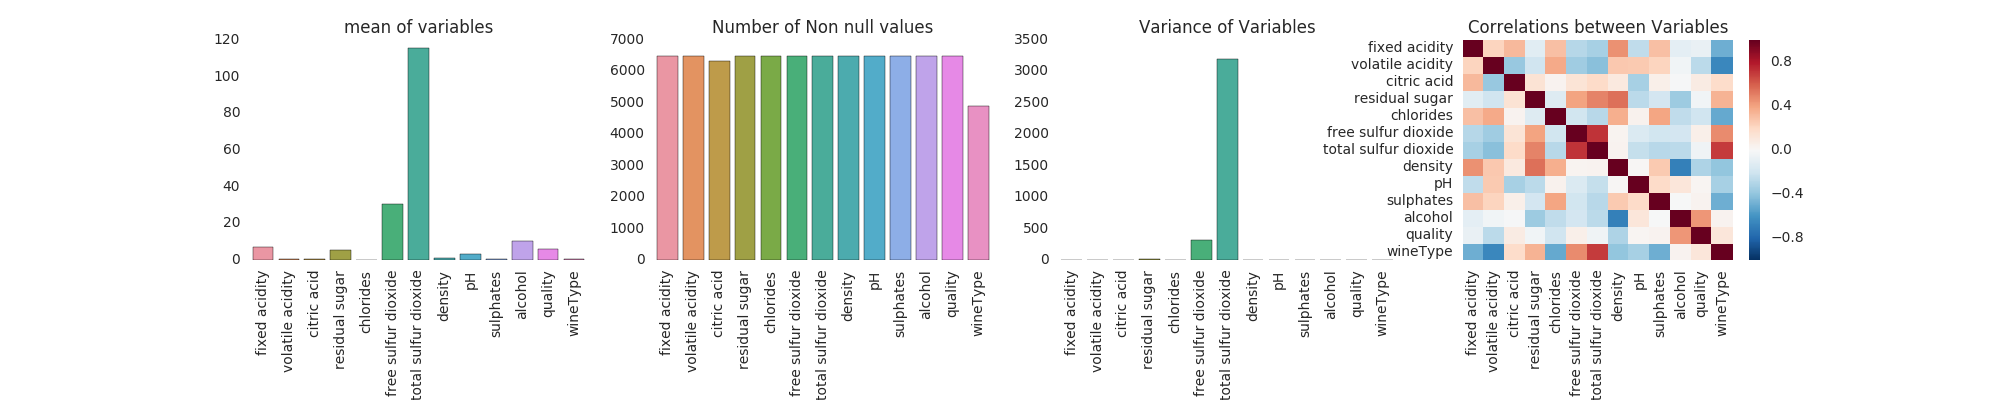

In [56]:
#fig, ax = plt.subplots()
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
#plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.35)
plt.xticks(rotation=90)
plt.title("mean of variables")
display(sns.barplot(x=wineData.columns, y=summary.mean()).figure)
plt.subplot(1,4,2)
plt.xticks(rotation=90)
plt.title("Number of Non null values")
display(sns.barplot(x=wineData.columns, y=summary.numNonzeros()).figure)
plt.subplot(1,4,3)
plt.xticks(rotation=90)
plt.title("Variance of Variables")
display(sns.barplot(x=wineData.columns, y=summary.variance()).figure)
plt.subplot(1,4,4)
plt.title("Correlations between Variables")
display(sns.heatmap(Statistics.corr(wineRdd, method="pearson"), 
                    xticklabels = wineData.columns, yticklabels = wineData.columns).figure)

## 4.3 Learning Regression model

In [58]:
def splittingData(data, prob, seedValue) :
  tempWhite = data.filter(data.wineType == 1)
  tempRed = data.filter(data.wineType == 0)
  redTrain, redTest = tempRed.randomSplit(prob, seedValue)
  whiteTrain, whiteTest = tempWhite.randomSplit(prob, seedValue)
  
  trainingSet = whiteTrain.union(redTrain)
  trainingSetRows = sc.parallelize(trainingSet.rdd.map(lambda x : list(x)).collect())
  labeledTraining = sc.parallelize([clt.LabeledPoint(x[-1], x[0:(len(x)-1)]) for x in trainingSetRows.collect()])
  
  testSet = whiteTest.union(redTest)
  testSetRows = sc.parallelize(testSet.rdd.map(lambda x : list(x)).collect())
  realLabels = testSetRows.map(lambda x : x[-1])
  testSet = sc.parallelize([x[0:(len(x)-1)] for x in testSetRows.collect()])
  
  return labeledTraining, testSet, realLabels


def meanComputation(list1, list2) :
  tempCount = 0
  for i in range(len(list1)) :
    if list1[i] == list2[i] :
      tempCount += 1
  return 1 - (tempCount/len(list1))

In [59]:
nbSimulations = 10
prob = [0.8, 0.2]
svmsgdErrors = list()
for i in range(nbSimulations) :
  trainSet , testSet , realLabels= splittingData(wineData, prob, i)
  model = clt.SVMWithSGD.train(trainSet)
  prediction = model.predict(testSet)
  svmsgdErrors.append(meanComputation(prediction.collect(), realLabels.collect()))

#5.Train another model using Pipelines:

### 5.1 Creating a pipeline with at least one feature extraction/manipulation and one model estimator

In [62]:
import pandas as pd
from collections import namedtuple
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.externals import joblib

# Seperate features and variable from the original dataset
# In order to use the function "train_test_split", we have to convert spark.sql.DataFrame to pandas DataFrame
wineData.select("quality").show()

X=wineData.drop('quality').toPandas()
y=wineData[['quality']].toPandas() 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=22,stratify=y)

# We create a pipeline with two steps: Data Standardization and random forest alogorithm
pipeline = make_pipeline(preprocessing.StandardScaler(),RandomForestRegressor(n_estimators=100))
# Set parameters

pipeline.get_params() 
parameters = {'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],'randomforestregressor__min_samples_leaf':[1,2],'randomforestregressor__max_depth': [None, 5, 3, 1]}
### max_features: The number of features to consider when looking for the best split: 
# If “auto”, then max_features=n_features.
# If “sqrt”, then max_features=sqrt(n_features).
# If “log2”, then max_features=log2(n_features).

### min_samples_leafThe minimum number of samples required to split an internal node

### max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

### 5.2 Fitting the pipeline to the training data

In [64]:
#Fit the pipeline and cross validation to check the model 
gs = GridSearchCV(pipeline, parameters, cv=3)
gs.fit(X_train, y_train)

### 5.3 Applying the model to the test data and computing the errors

In [66]:
y_pred = gs.predict(X_test)
print ("score = %3.2f" %(gs.score(X_test,y_test)))
print("Tuned Model Parameters: {}".format(gs.best_params_))
print("R-squared score：{}" .format(r2_score(y_test, y_pred)))
print("Mean squated error: {}".format(mean_squared_error(y_test, y_pred)))
print("R-squared score: {}".format(gs.score(X_test, y_test)))

# save training model
joblib.dump(gs, 'rf_regressor.pkl')

## 6. distributing tuning of scikit learn meta-parameters

In this section we tune the random forest hyper parameter "max_depth" by cross validation in parrallel (using Spark). On each fold we try various values for max_depth. Each (fold, max_depth) corresponds to a task which can be executed in parallel; Meaning that a model is fitted on a specific fold with a specific parameter on each node

In [69]:
# We initialize the cross validation kf which will be used in the function trainOneModel
numFolds = 3 # 3 folds
ntrain = len(y_train)
kf = cross_validation.KFold(ntrain, n_folds=numFolds)

In [70]:
# setting the list of max_depths we want to test the performance for
max_depths = np.arange(10,15, 1)

In [71]:
# Create a list of tasks to distribute : (max_depth, fold)
tasks = []
for max_depth in max_depths:
  for fold in range(numFolds):
    tasks = tasks + [(max_depth, fold)]

In [72]:
# distributing the list of tuples : tasksRDD
tasksRDD = sc.parallelize(tasks, numSlices = len(tasks))

In [73]:
# broadcasting the Training features and training labels for more efficient access to the data on each node
trainingFeaturesBroadcast = sc.broadcast(X_train.values)
trainingLabelsBroadcast = sc.broadcast(y_train.values)

In [74]:
def trainOneModel(max_depth, fold):
  """
  Given 1 task (1 hyperparameter alpha value + 1 fold index), train the corresponding model.
  Return: model, score on the fold's test data, task info.
  """
  # Extract indices for this fold
  trainIndex, valIndex = [], []
  fold_ = 0 # index into folds 'kf'
  for trainIndex_, valIndex_ in kf:
    if fold_ == fold:
      trainIndex, valIndex = trainIndex_, valIndex_
      break
    fold_ += 1
  # Get training data from the broadcast variables
  localTrainingFeatures = trainingFeaturesBroadcast.value
  localTrainingLabels = trainingLabelsBroadcast.value
  X_train, X_val = localTrainingFeatures[trainIndex], localTrainingFeatures[valIndex]
  Y_train, Y_val = localTrainingLabels[trainIndex], localTrainingLabels[valIndex]
  # Train the model, and score it
  Forest = RandomForestRegressor(max_depth = max_depth, n_estimators=100)
  Forest.fit(X_train, Y_train)
  score = Forest.score(X_val, Y_val)
  return Forest, score, max_depth, fold

In [75]:
# On each node where there is a tuple (max_depth, fold) from tasksRDD, run trainOneModel(max_depth, fold)
trainedModelAndScores = tasksRDD.map(lambda depth_fold: trainOneModel(depth_fold[0], depth_fold[1]))
trainedModelAndScores.cache()
trainedModelAndScores.count()

In [76]:
# clean up broadcast variables
trainingFeaturesBroadcast.unpersist()
trainingLabelsBroadcast.unpersist()

In [77]:
# Collect the results.
allScores = trainedModelAndScores.map(lambda x: (x[1], x[2], x[3])).collect()

In [78]:
# Average scores over folds for each max_depth
avgScores = dict(map(lambda max_depth: (max_depth, 0.0), max_depths))
for score, max_depth, fold in allScores:
  avgScores[max_depth] += score
for max_depth in max_depths:
  avgScores[max_depth] /= numFolds
avgScores

In [79]:
# Find best score : bestMax_depth, bestScore
bestMax_depth = -1
bestScore = -1
for max_depth in max_depths:
  if avgScores[max_depth] > bestScore:
    bestMax_depth = max_depth
    bestScore = avgScores[max_depth]
print('Found best alpha: %g, which gives score: %g' % (bestMax_depth, bestScore))

In [80]:
# Put in a dataframe and plot score vs max_depth
Score = namedtuple('Score', 'depth score')
df = spark.createDataFrame(map(lambda max_depth: Score(float(max_depth), float(avgScores[max_depth])), avgScores)).toDF('depth score','Score')
display(df)

In [81]:
# Corresponding plot with Seaborn
df = df.toPandas()
plt.figure(figsize=(4,3))
plt.gcf().subplots_adjust(bottom=0.15, left=0.20)
plt.ylim(0, 1)
display(sns.regplot(x="depth score", y="Score", data=df, fit_reg=False).figure)

In [82]:
# Use bestMax_depth, and train a final model.
tunedForest = RandomForestRegressor(max_depth = bestMax_depth, n_estimators = 100)
tunedForest.fit(np.array(X_train.values), np.array(y_train.values))

In [83]:
# measure scores (R squared) on training and hold out testing dataset
tunedTrainingScore, tunedTestScore = tunedForest.score(X_train, y_train), tunedForest.score(X_test, y_test)
print('Compare original model (without hyperparameter tuning) and final model (with tuning) on test data\n')
print('Model   \tmax_depth\tTraining   \tTest')
print('Tuned   \t%g\t%g\t%g' % (bestMax_depth, tunedTrainingScore, tunedTestScore))